In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

from neuropacks import NHP
from pyuoi.decomposition import UoI_CUR, CUR
from scipy.io import loadmat
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

In [2]:
paths = [
    '/Users/psachdeva/data/NHP/indy_20160407_02.mat',
    '/Users/psachdeva/data/NHP/indy_20160411_01.mat',
    '/Users/psachdeva/data/NHP/indy_20160411_02.mat',
    '/Users/psachdeva/data/NHP/indy_20160418_01.mat',
    '/Users/psachdeva/data/NHP/indy_20160419_01.mat'
]

In [3]:
nhps = []
Ys = []
for path in paths:
    nhp = NHP(data_path=path)
    nhps.append(nhp)
    Y = nhp.get_response_matrix(
        bin_width=0.25, region='M1', transform=None
    )
    nz_indices = np.argwhere(Y.sum(axis=0) > 0).ravel()
    Y = Y[:, nz_indices]
    Ys.append(Y)

In [ ]:
nhp.get_binned_positions()

In [5]:
n_columns_uois = []
n_columns_uois_alt = []

for ii, Y in enumerate(Ys):
    print(ii)
    ks = np.arange(1, Y.shape[1])
    n_ks = ks.size
    
    n_columns_uoi = np.zeros(n_ks)
    n_columns_uoi_alt = np.zeros(n_ks)
    
    for k_idx, k in enumerate(ks):
        uoicur = UoI_CUR(
            n_boots=20,
            max_k=k,
            boots_frac=0.8
        )
    
        uoicur.fit(Y)
        n_columns_uoi[k_idx] = uoicur.column_indices_.size
        uoicur.fit(Y, ks=int(k))
        n_columns_uoi_alt[k_idx] = uoicur.column_indices_.size
    
    n_columns_uois.append(n_columns_uoi)
    n_columns_uois_alt.append(n_columns_uoi_alt)

0
1
2
3
4


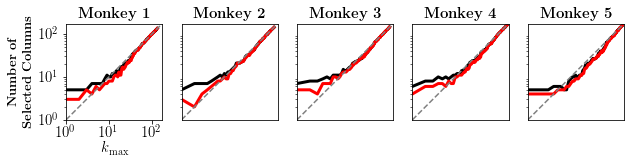

In [73]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2))

for ii in range(5):
    axes[ii].plot(n_columns_uois[ii], color='k', linewidth=3, alpha=1.)
    axes[ii].plot(n_columns_uois_alt[ii], color='r', linewidth=3, alpha=1.)
    axes[ii].set_xscale('log')
    axes[ii].set_yscale('log')
    axes[ii].set_xlim(left=1, right=175)
    axes[ii].set_ylim(bottom=1, top=175)
    axes[ii].set_yticks([])
    axes[ii].set_xticks([])
    axes[ii].set_aspect('equal')
    axes[ii].set_title(r'\textbf{Monkey %s}' %(ii+1), fontsize=15)
    axes[ii].tick_params(labelsize=15)
    axes[ii].plot([1, 175], [1, 175], color='gray', linestyle='--')

axes[0].set_xticks([1, 10, 100])
axes[0].set_yticks([1, 10, 100])

axes[0].set_xlabel(r'$k_{\text{max}}$', fontsize=15)
axes[0].set_ylabel(r'\textbf{Number of}' '\n' r'\textbf{Selected Columns}', fontsize=13)
plt.savefig('uoi_vs_intersection_comparison.pdf', bbox_inches='tight')

In [ ]:
max_k = 
uoi_cur = UoI_CUR(
    n_boots=20,
    max_k=max_k,
    boots_frac=0.8
)
uoi_cur2 = UoI_CUR(
    n_boots=20,
    max_k=max_k,
    boots_frac=0.8
)
cur = CUR(max_k=max_k)

# fits
uoi_cur.fit(Y)
uoi_cur2.fit(Y, ks=max_k)
cur.fit(Y, c=max_k+20)

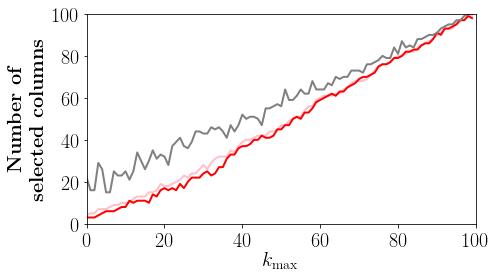

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(n_columns_uoi[0], color='pink', linewidth=2)
ax.plot(n_columns_uoi2[0], color='r', linewidth=2)
ax.plot(n_columns_cur[0], color='gray', linewidth=2)

ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
ax.set_xlabel(r'$k_{\text{max}}$', fontsize=20)
ax.set_ylabel(r'\textbf{Number of}' '\n' r'\textbf{selected columns}', fontsize=20)

plt.tight_layout()
plt.savefig('cur2.pdf')

In [139]:
k = 70

uoi_cur = UoI_CUR(
    n_boots=5,
    max_k=k,
    boots_frac=0.9
)
cur = CUR(max_k=k)

# fits
uoi_cur.fit(Y, ks=k, cs=k)
cur.fit(Y, c=k)

CUR(algorithm='randomized', max_k=70, n_iter=5, random_state=None, tol=0.0)

In [108]:
uoi_columns = uoi_cur.column_indices_
cur_columns = np.sort(cur.column_indices_[:uoi_columns.size])

print(uoi_columns)
print(cur_columns)

[  0   3   4   8  11  12  14  15  17  20  21  22  27  28  29  31  32  35
  43  44  45  46  50  52  55  57  61  62  64  68  69  76  77  78  80  82
  83  84  86  89  90  92  93  97  98  99 103 104 108 112 116 120 122 123
 124 125 126 127 132]
[  0   2   3   4   6   8  11  12  14  15  17  20  21  22  24  27  28  29
  31  32  35  37  44  45  46  49  52  57  61  62  63  66  68  69  71  76
  77  78  80  82  83  84  86  93  97  98 101 104 106 110 112 114 117 122
 123 125 126 127 132]


In [109]:
kf = KFold(n_splits=5, shuffle=True)
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(Y)):
    Y_train, pos_train_x, pos_train_y = Y[train_idx], cursor_pos[train_idx, 0], cursor_pos[train_idx, 1]
    Y_test, pos_test_x, pos_test_y = Y[test_idx], cursor_pos[test_idx, 0], cursor_pos[test_idx, 1]

    # decode with uoi columns
    ols = LinearRegression()
    ols.fit(Y_train[:, uoi_columns], pos_train_x)
    print('UoI x: ', ols.score(Y_test[:, uoi_columns], pos_test_x))

    # decode with cur columns
    ols = LinearRegression()
    ols.fit(Y_train[:, cur_columns], pos_train_x)
    print('CUR x: ', ols.score(Y_test[:, cur_columns], pos_test_x))

    ols = LinearRegression()
    ols.fit(Y_train[:, uoi_columns], pos_train_y)
    print('UoI y: ', ols.score(Y_test[:, uoi_columns], pos_test_y))

    ols = LinearRegression()
    ols.fit(Y_train[:, cur_columns], pos_train_y)
    print('CUR y: ', ols.score(Y_test[:, cur_columns], pos_test_y))
    
    ols = LinearRegression()
    ols.fit(Y_train, pos_train_x)
    print('Total x: ', ols.score(Y_test, pos_test_x))
    
    ols = LinearRegression()
    ols.fit(Y_train, pos_train_y)
    print('Total y: ', ols.score(Y_test, pos_test_y))
    
    print('--')

UoI x:  0.18327244385273145
CUR x:  0.20303930517449187
UoI y:  0.26832082224796217
CUR y:  0.2262800942831691
Total x:  0.3210512872495973
Total y:  0.33895954853127874
--
UoI x:  0.2260931799535444
CUR x:  0.24101276772241254
UoI y:  0.3120989662711424
CUR y:  0.2987573573661846
Total x:  0.3449356267040572
Total y:  0.39996250412826095
--
UoI x:  0.18573240217586917
CUR x:  0.17670685439102296
UoI y:  0.24869277637539855
CUR y:  0.23676457942431958
Total x:  0.3083422643317357
Total y:  0.323195100647806
--
UoI x:  0.1925079760228705
CUR x:  0.19542437572810345
UoI y:  0.2589102020022509
CUR y:  0.20116957963452353
Total x:  0.3028619490221824
Total y:  0.2932461827811417
--
UoI x:  0.15992905413828162
CUR x:  0.17971933964749542
UoI y:  0.2397942042102473
CUR y:  0.18735876898785242
Total x:  0.2996198201467437
Total y:  0.31662520682488315
--


In [114]:
max_ks = np.arange(25, 150, 5)
n_max_ks = max_ks.size
n_splits = 10
uoi_columns_dict = {}
cur_columns_dict = {}
uoi_decoding = np.zeros(n_max_ks)
cur_decoding = np.zeros(n_max_ks)
uoi_scores_x = np.zeros((n_max_ks, n_splits))
uoi_scores_y = np.zeros(uoi_scores_x.shape)
cur_scores_x = np.zeros(uoi_scores_x.shape)
cur_scores_y = np.zeros(uoi_scores_x.shape)

In [ ]:
for k_idx, max_k in enumerate(max_ks):
    uoi_cur = UoI_CUR(
        n_boots=20,
        max_k=max_k,
        boots_frac=0.8
    )
    uoi_cur.fit(Y)

    uoi_columns = uoi_cur.columns_
    uoi_columns_dict[k_idx] = uoi_columns
    
    n_columns = uoi_columns.size
    
    cur = CUR(max_k=max_k)
    cur.fit(Y, c=n_columns)
    cur_columns = np.sort(cur.columns_[:n_columns])
    cur_columns_dict[k_idx] = cur_columns
    
    Y_uoi = Y[:, uoi_columns]
    Y_cur = Y[:, cur_columns]
    
    Y_uoi_err = Y - np.dot(Y_uoi, np.dot(np.linalg.pinv(Y_uoi), Y))
    Y_cur_err = Y - np.dot(Y_cur, np.dot(np.linalg.pinv(Y_cur), Y))
    uoi_decoding[k_idx] = np.sum(np.abs(Y_uoi_err))/Y.size
    cur_decoding[k_idx] = np.sum(np.abs(Y_cur_err))/Y.size

    kf = KFold(n_splits=10)
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(Y)):
        Y_train, pos_train_x, pos_train_y = Y[train_idx], cursor_pos[train_idx, 0], cursor_pos[train_idx, 1]
        Y_test, pos_test_x, pos_test_y = Y[test_idx], cursor_pos[test_idx, 0], cursor_pos[test_idx, 1]

        # decode with uoi columns
        ols = LinearRegression()
        ols.fit(Y_train[:, uoi_columns], pos_train_x)
        uoi_scores_x[k_idx, fold_idx] = ols.score(Y_test[:, uoi_columns], pos_test_x)
        
        ols = LinearRegression()
        ols.fit(Y_train[:, uoi_columns], pos_train_y)
        uoi_scores_y[k_idx, fold_idx] = ols.score(Y_test[:, uoi_columns], pos_test_y)

        # decode with cur columns
        ols = LinearRegression()
        ols.fit(Y_train[:, cur_columns], pos_train_x)
        cur_scores_x[k_idx, fold_idx] = ols.score(Y_test[:, cur_columns], pos_test_x)
        
        ols = LinearRegression()
        ols.fit(Y_train[:, cur_columns], pos_train_y)
        cur_scores_y[k_idx, fold_idx] = ols.score(Y_test[:, cur_columns], pos_test_y)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axes[0].plot(max_ks, np.median(uoi_scores_x, axis=1), color='r', linewidth=3)
axes[0].plot(max_ks, np.median(cur_scores_x, axis=1), color='k', linewidth=3)

axes[1].plot(max_ks, np.median(uoi_scores_y, axis=1), color='r', linewidth=3, label=r'\textbf{UoI}$_{\textbf{CSS}}$')
axes[1].plot(max_ks, np.median(cur_scores_y, axis=1), color='k', linewidth=3, label=r'\textbf{CSS}')

axes[1].set_xlabel(r'$k_{\text{max}}$', fontsize=25)

fig.text(
    x=-0.025, y=0.55, s=r'\textbf{Explained}' '\n' r'\textbf{Variance}',
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=23
)
axes[0].set_ylabel(r'$x$ position', fontsize=23)
axes[1].set_ylabel(r'$y$ position', fontsize=23)

axes[1].set_xlim([25, 145])
axes[1].set_xticks([25, 50, 75, 100, 125, 145])

axes[1].legend(loc=4, prop={'size': 20})

axes[0].set_title(r'\textbf{Hand Position Decoding Accuracy}', fontsize=25)
plt.tight_layout()

plt.savefig('m1_cur_decoding_position.pdf', bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axes[0].plot(max_ks, uoi_decoding, color='r', linewidth=3, label=r'\textbf{UoI}$_{\textbf{CSS}}$')
axes[0].plot(max_ks, cur_decoding, color='k', linewidth=3, label=r'\textbf{CSS}')

axes[0].set_xlim([25, 145])
axes[0].set_xticks([25, 50, 75, 100, 125, 145])

axes[0].set_ylabel(r'\textbf{Error}', fontsize=22)
axes[0].set_title(r'\textbf{Reconstruction Error of Data Matrix}', fontsize=23)
axes[0].legend(loc=0, prop={'size': 20})


axes[1].plot(
    max_ks, [uoi_columns_dict[key].size for key in uoi_columns_dict.keys()],
    color='k',
    linewidth=3)

axes[1].set_xlim([25, 145])
axes[1].set_xticks([25, 50, 75, 100, 125, 145])

axes[1].set_title(r'\textbf{Number of Columns Selected}', fontsize=23)
axes[1].set_xlabel(r'$k_{\text{max}}$', fontsize=25)
axes[1].set_ylabel(r'\textbf{Num. Columns}', fontsize=22)
                   
plt.tight_layout()
plt.savefig('m1_cur_error.pdf', bbox_inches='tight')

In [ ]:
results = h5py.File('cur_results.h5', 'w')
results['uoi_decoding_x'] = uoi_scores_x
results['uoi_decoding_y'] = uoi_scores_y
results['cur_decoding_x'] = cur_scores_x
results['cur_decoding_y'] = cur_scores_y
results['uoi_reconstruction'] = uoi_decoding
results['cur_reconstruction'] = cur_decoding
results.attrs['file'] = 'indy_20160411_01.mat'
results.attrs['bin_size'] = 0.25
for idx, column in uoi_columns_dict.items():
    results['uoi_columns/' + str(max_ks[idx])] = column
    
for idx, column in cur_columns_dict.items():
    results['cur_columns/' + str(max_ks[idx])] = column
results.close()

In [ ]:
results = h5py.File()